In [1]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-21 16:38:45.271889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
adata = sc.read("../../data/adata_pancreas_2019_endocrine.h5ad")
sc.pp.pca(adata, n_comps=30)
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)
#sc.pl.umap(adata, color="celltype")

In [3]:
source_train = adata.obsm["X_pca"]
target_train = adata.obsm["X_pca"]


In [4]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_train.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)
bridge_net = MLP_bridge(target_train.shape[1], 1)


otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-2, scale_cost="mean", input_dim=30, output_dim=30, iterations=10_000, k_noise_per_x=1)

2023-09-21 16:41:23.888268: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
otfm(source_train, target_train, 1024, 1024)

100%|██████████| 10000/10000 [01:41<00:00, 98.62it/s]


In [6]:
push_source = [None] * 30

for i in range(30):
    push_source[i] = otfm.transport(source_train, seed=i)[0][0,...]
    

# Downstream analysis

In [7]:
from typing import Any, Iterable, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


def sample_velocities_from_transport_matrix(
    transport_matrix: np.ndarray, target_distribution: np.ndarray, n_samples: int
) -> np.ndarray:
    res = [None] * n_samples
    for i in range(n_samples):
        res[i] = target_distribution[
            jax.vmap(lambda x: jax.random.categorical(jax.random.PRNGKey(i), x))(jnp.log(transport_matrix))
        ]
    return jnp.asarray(res)


def compute_statistics_from_samples(
    samples: np.ndarray, split_to_k_batches: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    batch_size = samples.shape[0] // split_to_k_batches
    assert samples.shape[0] % split_to_k_batches == 0
    # samples is of shape (n_samples, n_cells, dim_velocity_vector)
    df = pd.DataFrame(index=cell_names)

    for i in range(split_to_k_batches):
        df[f"var_{i}"] = np.sum(np.var(samples[i * batch_size : (i + 1) * batch_size, ...], axis=0), axis=1)
        var_cols = [f"var_{i}" for i in range(split_to_k_batches)]

    df["var_of_variance"] = df[var_cols].var(axis=1)
    df["mean_of_variance"] = df[var_cols].mean(axis=1)
    return df


def compute_directional_statistics_from_samples(
    samples: np.ndarray, n_jobs: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    samples = np.asarray(samples)
    n_cells = len(cell_names)
    df = pd.DataFrame(index=cell_names)
    df["directional_variance"] = np.nan
    df["directional_difference"] = np.nan
    df["directional_cosine_sim_variance"] = np.nan
    df["directional_cosine_sim_difference"] = np.nan
    df["directional_cosine_sim_mean"] = np.nan
    results = Parallel(n_jobs=n_jobs, verbose=3)(
        delayed(_directional_statistics_per_cell)(samples[:, cell_index, :]) for cell_index in range(n_cells)
    )
    # cells by samples
    cosine_sims = np.stack([results[i][0] for i in range(n_cells)])
    df.loc[:, "directional_cosine_sim_variance"] = [results[i][1] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_difference"] = [results[i][2] for i in range(n_cells)]
    df.loc[:, "directional_variance"] = [results[i][3] for i in range(n_cells)]
    df.loc[:, "directional_difference"] = [results[i][4] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_mean"] = [results[i][5] for i in range(n_cells)]

    return df, cosine_sims


def _cosine_sim(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """Returns cosine similarity of the vectors."""
    v1_u = _centered_unit_vector(v1)
    v2_u = _centered_unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)


def _directional_statistics_per_cell(
    tensor: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Internal function for parallelization.

    Parameters
    ----------
    tensor
        Shape of samples by genes for a given cell.
    """
    n_samples = tensor.shape[0]
    # over samples axis
    mean_velocity_of_cell = tensor.mean(0)
    cosine_sims = [_cosine_sim(tensor[i, :], mean_velocity_of_cell) for i in range(n_samples)]
    angle_samples = [np.arccos(el) for el in cosine_sims]
    return (
        cosine_sims,
        np.var(cosine_sims),
        np.percentile(cosine_sims, 95) - np.percentile(cosine_sims, 5),
        np.var(angle_samples),
        np.percentile(angle_samples, 95) - np.percentile(angle_samples, 5),
        np.mean(cosine_sims),
    )


def _centered_unit_vector(vector: np.ndarray) -> np.ndarray:
    """Returns the centered unit vector of the vector."""
    vector = vector - np.mean(vector)
    return vector / np.linalg.norm(vector)

In [8]:
cosine_vars_source = compute_directional_statistics_from_samples(np.array(push_source), 2, adata[adata.obs["day"]=="14.5"].obs_names)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   15.9s
[Parallel(n_jobs=2)]: Done 4388 tasks      | elapsed:   21.4s
[Parallel(n_jobs=2)]: Done 4417 out of 4417 | elapsed:   21.5s finished


In [9]:
adata.obs["directional_cosine_sim_variance"] = cosine_vars_source[0]["directional_cosine_sim_variance"]

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


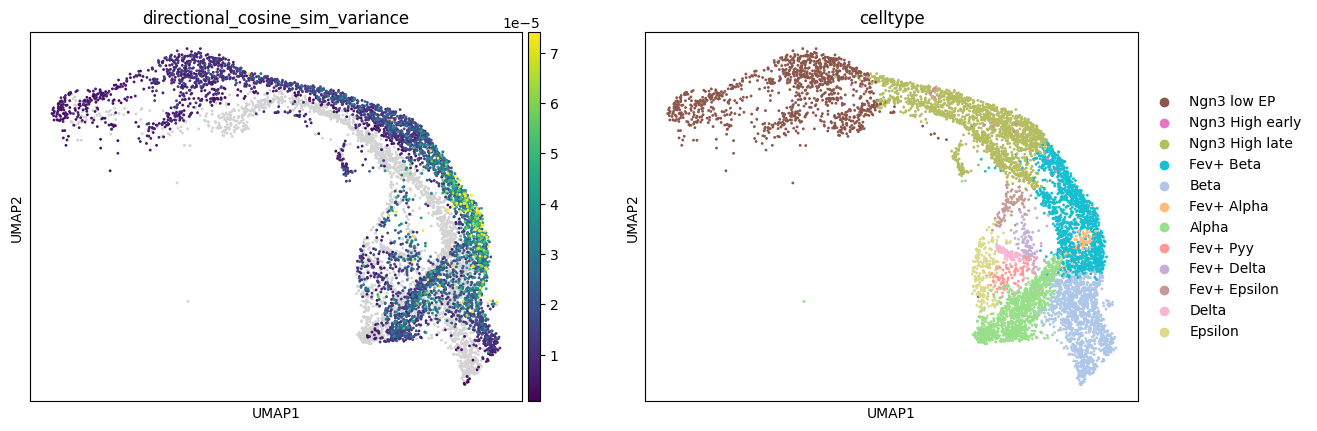

In [10]:
sc.pl.umap(adata, color=["directional_cosine_sim_variance", "celltype"], vmax="p99", )

In [11]:
cell_types = ["Ngn3 low EP", "Ngn3 High early", "Ngn3 High late", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+ Epsilon", "Fev+ Pyy", "Alpha", "Beta", "Delta", "Epsilon"]
adata.obs["cell_type_ordered"] = pd.Categorical(adata.obs.celltype, categories=cell_types, ordered=True)

Text(0.5, 0, 'Cell type')

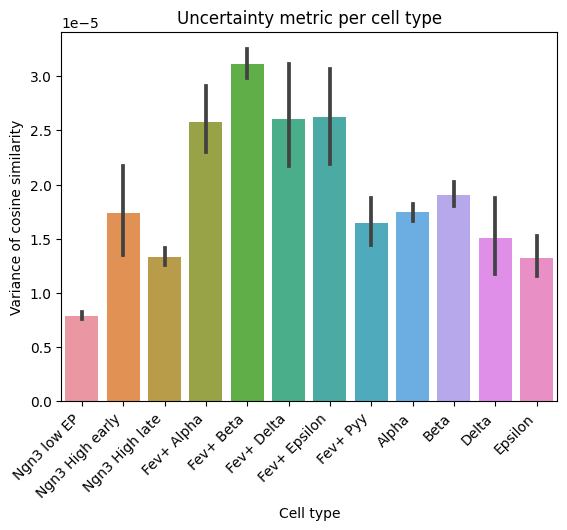

In [12]:
import seaborn as sns
g = sns.barplot(adata.obs, x="cell_type_ordered", y="directional_cosine_sim_variance")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Uncertainty metric per cell type")
g.set_ylabel("Variance of cosine similarity")
g.set_xlabel("Cell type")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


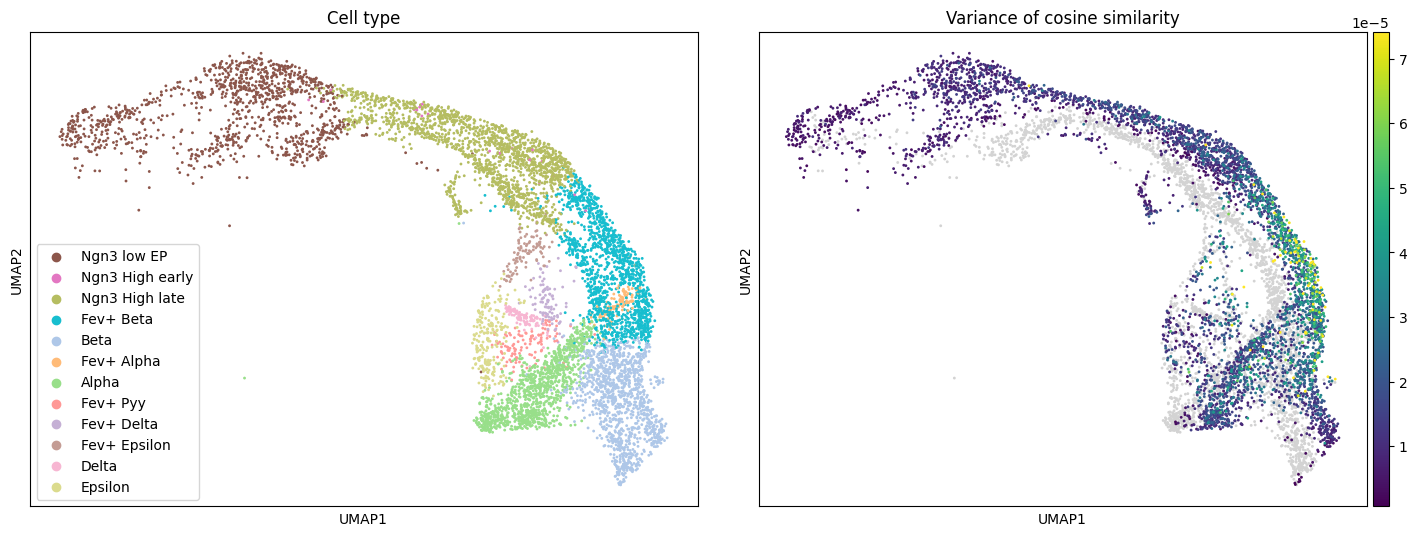

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["celltype"], vmax="p99", show=False, ax=ax1)
sc.pl.umap(adata, color=["directional_cosine_sim_variance"], vmax="p99", show=False, ax=ax2)
ax1.legend()
ax1.set_title("Cell type")
ax2.set_title("Variance of cosine similarity")
plt.tight_layout(pad=3.0)
plt.show()